In [127]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.impute import SimpleImputer
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.impute import SimpleImputer
import scipy.stats as st

In [128]:
datascienceprogram_dataset = 'datascience_programs_list.csv'
data = pd.read_csv(datascienceprogram_dataset)

In [131]:
# EDA
print("Dataset Background Info:")
print(data.info())

Dataset Background Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 443 entries, 0 to 442
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Subject Name         443 non-null    object
 1   University Name      443 non-null    object
 2   Per Year Fees        436 non-null    object
 3   About Program        443 non-null    object
 4   Program Duration     427 non-null    object
 5   University Location  443 non-null    object
 6   Program Name         443 non-null    object
dtypes: object(7)
memory usage: 24.4+ KB
None


In [133]:
descriptive_stats = data.describe(include='all')
print(descriptive_stats)

        Subject Name           University Name      Per Year Fees  \
count            443                       443                436   
unique           199                       276                339   
top     Data Science  Arizona State University  26,655 EUR / year   
freq             135                        13                 10   

                                            About Program Program Duration  \
count                                                 443              427   
unique                                                434               22   
top     Data Analysis and Research Psychology (Online)...           1 year   
freq                                                    2              258   

       University Location                   Program Name  
count                  443                            443  
unique                 163                             40  
top                 Online  M.Sc. / Full-time / On Campus  
freq                   

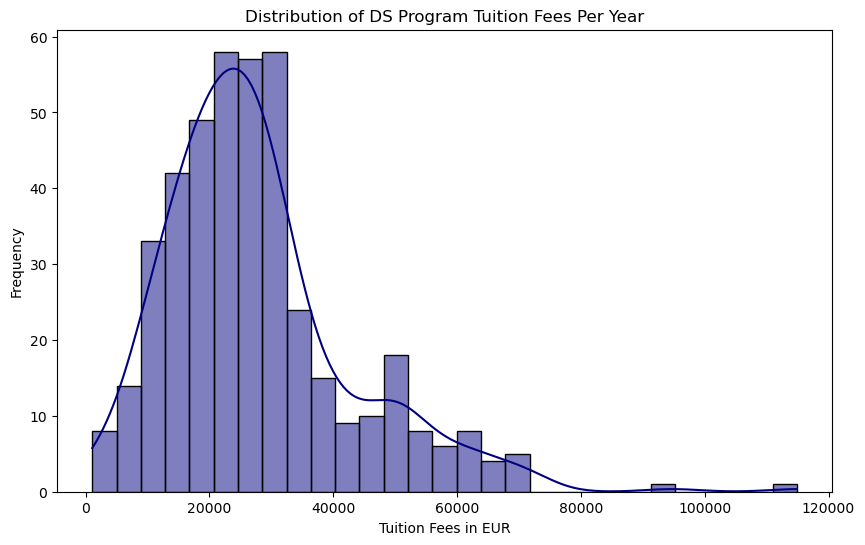

In [135]:
data['Program Duration'].fillna('Unknown', inplace=True)
data['Per Year Fees'] = data['Per Year Fees'].str.extract('(\d+,\d+)').replace(',', '', regex=True).astype(float)

plt.figure(figsize=(10, 6))
sns.histplot(data['Per Year Fees'].dropna(), kde=True, color = 'navy')
plt.title('Distribution of DS Program Tuition Fees Per Year')
plt.xlabel('Tuition Fees in EUR')
plt.ylabel('Frequency')
plt.show()

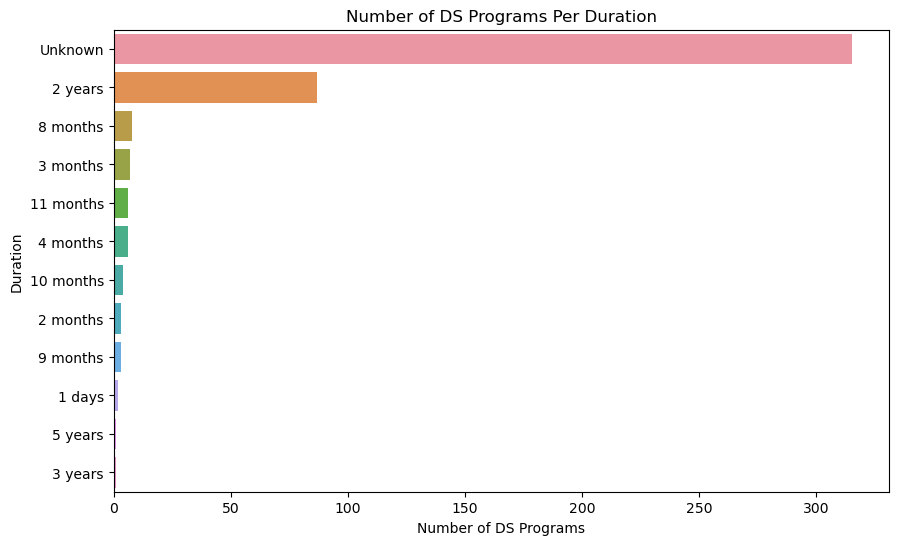

In [137]:
data['Program Duration'] = data['Program Duration'].str.extract('(\d+ years|\d+ months|\d+ weeks|\d+ days|\d+ hours)')
data['Program Duration'] = data['Program Duration'].fillna('Unknown')

plt.figure(figsize=(10, 6))
sns.countplot(y=data['Program Duration'], order=data['Program Duration'].value_counts().index)
plt.title('Number of DS Programs Per Duration')
plt.xlabel('Number of DS Programs')
plt.ylabel('Duration')
plt.show()

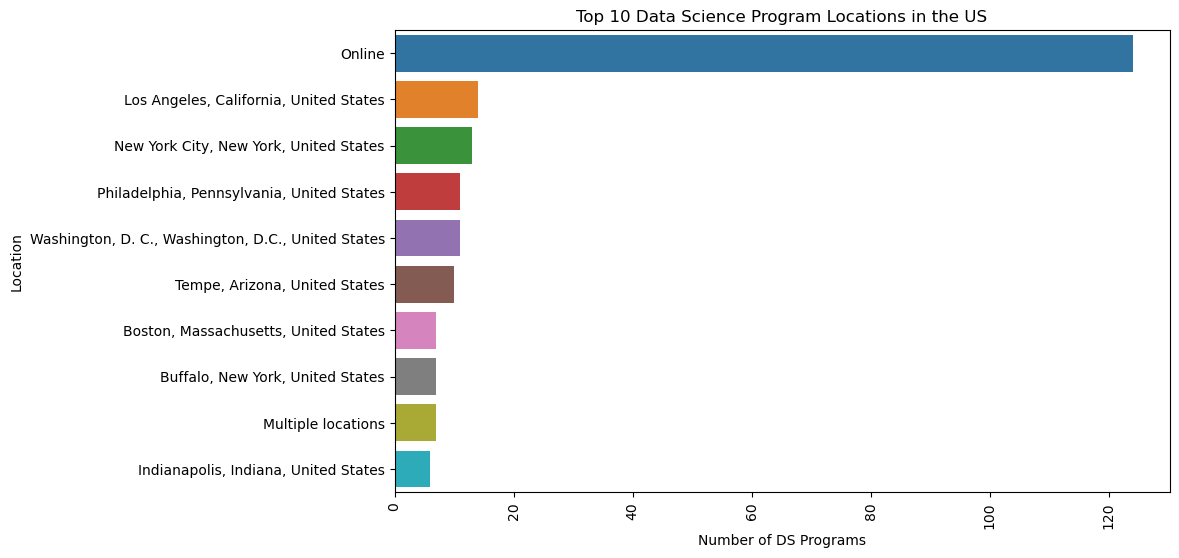

In [139]:
top10_loc = data['University Location'].value_counts().nlargest(10).index

plt.figure(figsize=(10, 6))
sns.countplot(y=data[data['University Location'].isin(top10_loc)]['University Location'], 
              order=data['University Location'].value_counts().nlargest(10).index)
plt.title('Top 10 Data Science Program Locations in the US')
plt.xlabel('Number of DS Programs')
plt.ylabel('Location')
plt.xticks(rotation=90)
plt.show()

In [143]:
# Feature Engineering & Transformations
imputer = SimpleImputer(strategy='mean')
data_imputed = imputer.fit_transform(data[['Per Year Fees', 'University Location', 'Program Duration', 'Program Name']])

data['Program Duration'] = data['Program Duration'].fillna('1 year')

label_encoder = LabelEncoder()
data['University Location'] = label_encoder.fit_transform(data['University Location'])
data['Program Name'] = label_encoder.fit_transform(data['Program Name'])
data['Program Duration'] = label_encoder.fit_transform(data['Program Duration'])

scaler = StandardScaler()
data[['Per Year Fees']] = scaler.fit_transform(data[['Per Year Fees']])

print(pd.DataFrame(data_imputed, columns=['Per Year Fees', 'University Location', 'Program Duration', 'Program Name']).isnull().sum())
print(pd.DataFrame(data_imputed, columns=['Per Year Fees', 'University Location', 'Program Duration', 'Program Name']).head())

Per Year Fees          0
University Location    0
Program Duration       0
Program Name           0
dtype: int64
   Per Year Fees  University Location  Program Duration  Program Name
0   1.120599e-16                115.0              11.0          39.0
1  -1.744374e+00                115.0               1.0          39.0
2  -4.677339e-01                 49.0              11.0          33.0
3  -6.047212e-01                115.0              11.0          37.0
4  -3.951609e-01                149.0               4.0           9.0


In [175]:
# Model Implementation (RFR)
X = data_imputed
y = data['Subject Name']

y = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

cv_scores = cross_val_score(model, X_train, y_train, cv=5)
print(f'Cross-validation scores: {cv_scores}')
print(f'Avg cross-validation score: {cv_scores.mean()}')

# Prediction
y_pred = model.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f'RMSE: {rmse}')

Cross-validation scores: [-0.08003016 -0.12663238 -0.20365013  0.03774098 -0.10361881]
Avg cross-validation score: -0.09523809816078113
RMSE: 50.77378572641182


In [173]:
# Model Selection: Regularization & Cross-validation (Ridge Regression Model)
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train, y_train)

ridge_cv = cross_val_score(ridge_model, X_train, y_train, cv=5)
print(f'Ridge Cross-validation scores: {ridge_cv}')
print(f'Avg Ridge cross-validation score: {ridge_cv.mean()}')

Ridge Cross-validation scores: [-0.05276326 -0.03705034 -0.02556697 -0.1409417  -0.19301949]
Avg Ridge cross-validation score: -0.08986835120727607


In [155]:
# Predictions and evaluation
ridge_y_pred = ridge_model.predict(X_test)
ridge_RMSE = mean_squared_error(y_test, ridge_y_pred, squared=False)
print(f'Ridge RMSE: {ridge_RMSE}')

results = {
    "Random Forest RMSE": rmse,
    "Ridge RMSE": ridge_RMSE,
    "Random Forest Cross-validation": cv_scores.mean(),
    "Ridge Cross-validation": ridge_cv.mean()
}
print(results)

Ridge RMSE: 46.5331400751839
{'Random Forest RMSE': 50.77378572641182, 'Ridge RMSE': 46.5331400751839, 'Random Forest Cross-validation': -0.09523809816078113, 'Ridge Cross-validation': -0.08986835120727607}


In [165]:
# Gradient Boosting Model (Additional Model)
param_dist = {
    'n_estimators': st.randint(100, 200),
    'learning_rate': st.uniform(0.01, 0.1),
    'max_depth': st.randint(3, 7),
    'subsample': st.uniform(0.7, 1.0),
    'min_samples_split': st.randint(2, 10),
    'min_samples_leaf': st.randint(1, 10)
}

Gradient_Boosting = GradientBoostingRegressor(random_state=42)

random_search = RandomizedSearchCV(estimator=Gradient_Boosting, param_distributions=param_dist, n_iter=50, cv=5, n_jobs=-1, scoring='neg_mean_squared_error', random_state=42)
random_search.fit(X_train, y_train)

/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
170 fits failed out of a total of 250.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/sklearn/base.py", line 1144, in wrapper
    estimator._validate_params()
  File "/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/sklearn/ba

RandomizedSearchCV(cv=5, estimator=GradientBoostingRegressor(random_state=42),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7fe2aa2cc950>,
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fe28a6b7c50>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastru...ct at 0x7fe28a6b2090>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fe28a6b1890>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fe28a6ae810>,
                                        'subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7fe28a6b1590>},
                   random_state=42, scoring='neg_mean_squared_error')

In [171]:
# Check for the best model from RS CV
opt_GBmodel = random_search.best_estimator_
print(f'Best parameters in RS: {random_search.best_params_}')

cv_scores = cross_val_score(opt_GBmodel, X_train, y_train, cv=5)
print(f'Cross-validation scores: {cv_scores}')
print(f'Avg cross-validation score: {cv_scores.mean()}')

Best parameters in RS: {'learning_rate': 0.011326496115986653, 'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 108, 'subsample': 0.7159662522202141}
Cross-validation scores: [ 0.01763915 -0.03221444  0.06557227 -0.01006909 -0.00976134]
Avg cross-validation score: 0.006233309035554769


In [162]:
# Prediction
y_pred = opt_GBmodel.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f'RMSE: {rmse}')

results = {
    "Gradient Boosting RMSE": rmse,
    "Gradient Boosting Cross-validation": cv_scores.mean()
}
print(results)

RMSE: 47.60900230252279
{'Gradient Boosting RMSE': 47.60900230252279, 'Gradient Boosting Cross-validation': 0.006233309035554769}
